100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 58.83it/s]


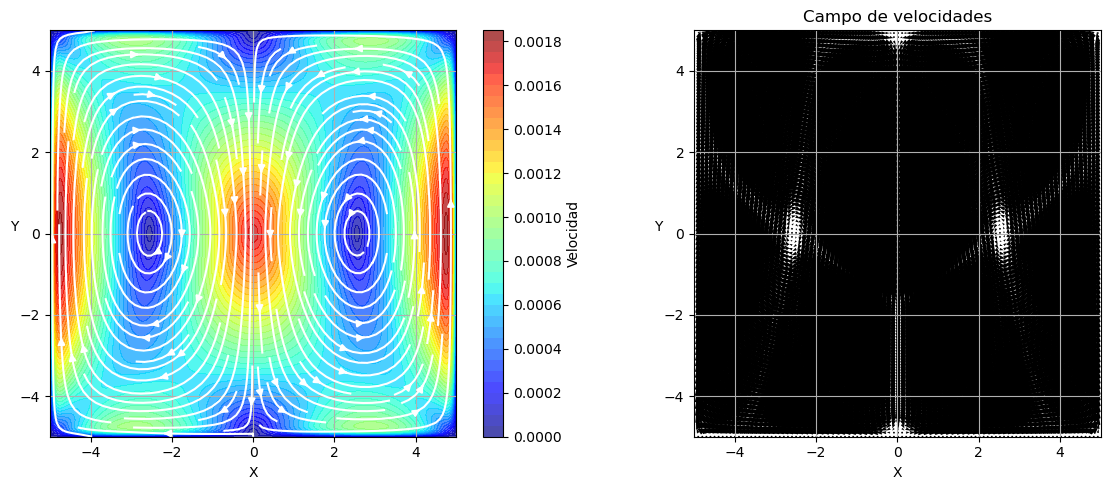

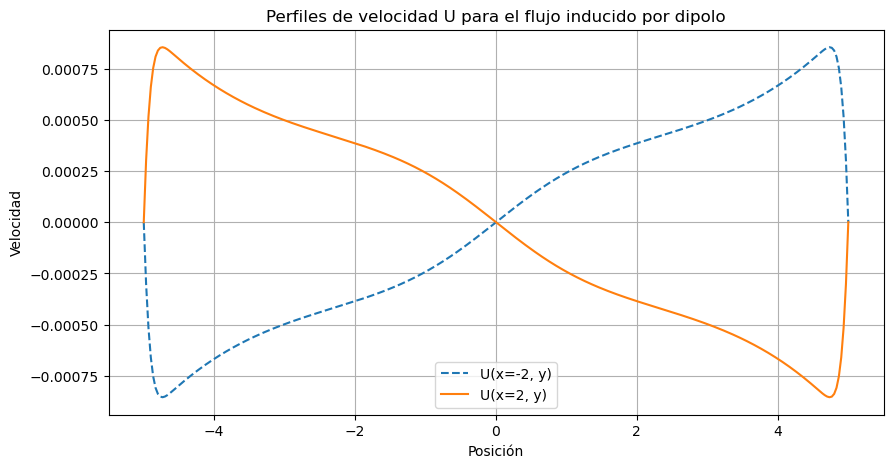

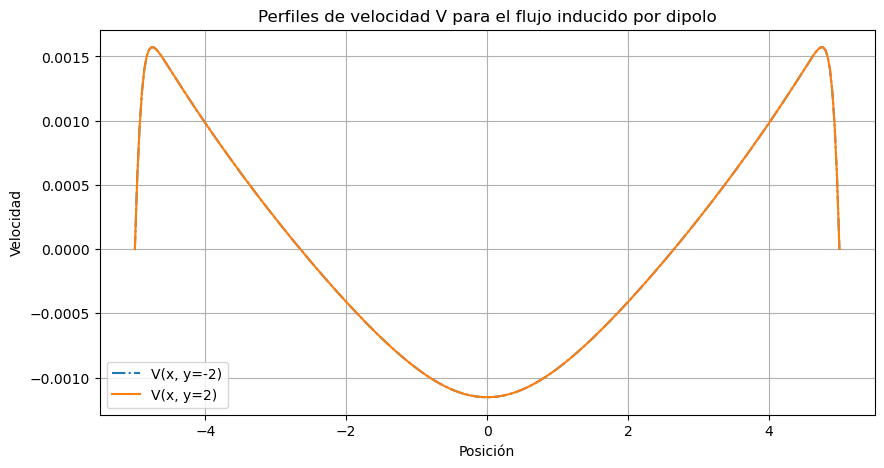

In [1]:
"""
Simulación Numérica de Flujo MHD de un dipolo

Este código implementa una simulación numérica del flujo de un fluido incompresible
Magnetohidrodinámico utilizando el método de diferencias finitas. Se resuelven
las ecuaciones de Navier-Stokes mediante un esquema de proyección temporal.
Asimismo se muestran dos formas de predicción de la ssoluciones de dicho sistema con PINNs e I-PINNs

Características principales:
- Resuelve las ecuaciones por medio de diferencias fintas
- Genera una predicción PINNs del mismo sistema
- Genera una predicción I-PINNs del mismo sistema con mejor resolución de predicción.
- Integra ecuaciones en el proceso de aprendizaje
- Utiliza datos de simulación directa como guía
- Impone condiciones de contorno físicamente relevantes
- Escala las derivadas para mejorar el entrenamiento

"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Simulation parameters
N_POINTS = 300  # Original resolution

DOMAIN_SIZE = 10.0  # Total domain size (-5 to 5)
N_ITERATIONS = 1000
TIME_STEP_LENGTH = 0.0001
RE = 10.0  # Reynolds number
KINEMATIC_VISCOSITY = 1.0/RE
DENSITY = 1.0

Q = 0.01   # Reduced Lorentz force parameter
N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

def compute_magnetic_field(X, Y):
    """Compute magnetic dipole field components"""
    # Center of the dipole
    x0, y0 = 0, 0
    r = np.sqrt((X - x0)**2 + (Y - y0)**2)
    r = np.where(r < 0.1, 0.1, r)  # Avoid division by zero
    
    Bx = 3 * (X - x0) * (Y - y0) / r**5
    By = (3 * (Y - y0)**2 - r**2) / r**5
    
    return Bx, By

def main():
    # Create mesh (keeping original domain -5 to 5)
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, N_POINTS)
    y = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, N_POINTS)
    X, Y = np.meshgrid(x, y)

    # Initialize fields
    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    
    # Compute magnetic field (constant throughout simulation)
    #Bx, By = compute_magnetic_field(X, Y)
    B_magnitude = np.sqrt(X**2 + Y**2)

    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * element_length)
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * element_length)
        return diff
    
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]
        ) / (element_length**2)
        return diff

    # Check stability
    max_time_step = 0.5 * element_length**2 / KINEMATIC_VISCOSITY
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * max_time_step:
        raise RuntimeError("Stability is not guaranteed")

    # Store velocity history
    u_history = []
    v_history = []
    
    for iter in tqdm(range(N_ITERATIONS)):
        # Compute gradients
        du_dx = central_difference_x(u)
        du_dy = central_difference_y(u)
        dv_dx = central_difference_x(v)
        dv_dy = central_difference_y(v)
        laplace_u = laplace(u)
        laplace_v = laplace(v)

        # Tentative velocity step
        u_tent = (
            u + TIME_STEP_LENGTH * (
                -(u * du_dx + v * du_dy) +
                KINEMATIC_VISCOSITY * laplace_u
            )
        )
        v_tent = (
            v + TIME_STEP_LENGTH * (
                -(u * dv_dx + v * dv_dy) +
                KINEMATIC_VISCOSITY * laplace_v +
                Q * B_magnitude  # Lorentz force term
            )
        )

        # Boundary conditions for tentative velocity
        u_tent[0, :] = u_tent[-1, :] = u_tent[:, 0] = u_tent[:, -1] = 0.0
        v_tent[0, :] = v_tent[-1, :] = v_tent[:, 0] = v_tent[:, -1] = 0.0

        # Pressure Poisson equation
        div_u = central_difference_x(u_tent) + central_difference_y(v_tent)
        rhs = DENSITY / TIME_STEP_LENGTH * div_u

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_new = np.zeros_like(p)
            p_new[1:-1, 1:-1] = 0.25 * (
                p[1:-1, 0:-2] + p[0:-2, 1:-1] + 
                p[1:-1, 2:] + p[2:, 1:-1] - 
                element_length**2 * rhs[1:-1, 1:-1]
            )
            
            # Pressure boundary conditions
            p_new[:, -1] = p_new[:, -2]
            p_new[0, :] = p_new[1, :]
            p_new[:, 0] = p_new[:, 1]
            p_new[-1, :] = p_new[-2, :]
            
            p = p_new

        # Velocity correction
        dp_dx = central_difference_x(p)
        dp_dy = central_difference_y(p)
        
        u_new = u_tent - TIME_STEP_LENGTH / DENSITY * dp_dx
        v_new = v_tent - TIME_STEP_LENGTH / DENSITY * dp_dy

        # Final boundary conditions
        u_new[0, :] = u_new[-1, :] = u_new[:, 0] = u_new[:, -1] = 0.0
        v_new[0, :] = v_new[-1, :] = v_new[:, 0] = v_new[:, -1] = 0.0

        # Update fields
        u = u_new
        v = v_new
        
        # Save every 20 time steps
        if iter % 20 == 0:
            u_history.append(u.copy())
            v_history.append(v.copy())


    ####################################################3333
    index_x_minus_2 = np.argmin(np.abs(x - (-2)))
    index_x_2 = np.argmin(np.abs(x - 2))
    index_y_minus_2 = np.argmin(np.abs(y - (-2)))
    index_y_2 = np.argmin(np.abs(y - 2))
    index_y_0 = np.argmin(np.abs(y - 0))

# Guardar los datos corregidos
    np.savetxt('u_x-2_y_DF_MHD.dat', u[:, index_x_minus_2], fmt='%.6f')
    np.savetxt('u_x2_y_DF_MHD.dat', u[:, index_x_2], fmt='%.6f')
    np.savetxt('v_x_y-2_DF_MHD.dat', v[index_y_minus_2, :], fmt='%.6f')
    np.savetxt('v_x_y2_DF_MHD.dat', v[index_y_2, :], fmt='%.6f')
    np.savetxt('v_x_y0_DF_MHD.dat', v[index_y_0, :], fmt='%.6f')
########################################################3
# Visualization
    plt.style.use("default")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot streamlines
    speed = np.sqrt(u**2 + v**2)
    skip = 3
# 1. Contour plot for background (velocity magnitude)
    contour = ax1.contourf(X, Y, speed, 40, cmap='jet', alpha=0.7)  # alpha for transparency

# 2. Quiver plot for velocity vectors
    quiver = ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                    u[::skip, ::skip], v[::skip, ::skip],
                    color='black',  # Color of the velocity arrows
                    scale=0.01,
                    width=0.005,
                    headwidth=2.5,
                    headlength=4,
                    headaxislength=4.5)

# Add colorbar for the contour plot (velocity magnitude)
    cbar = fig.colorbar(contour, ax=ax1, label='Velocidad')

    ax1.streamplot(X, Y, u, v, density=1.5, color='white')
   # ax1.set_title('Líneas de corriente')
    ax1.set_aspect('equal')
    ax1.set_xlim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax1.set_ylim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax1.set_xlabel('X', rotation=0)
    ax1.set_ylabel('Y', rotation=0)
    ax1.grid(True)

# Plot velocity field
    speed = np.sqrt(u**2 + v**2)
    
# Titles and labels
    ax2.set_title('Campo de velocidades')
    ax2.set_aspect('equal')
    ax2.set_xlim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax2.set_ylim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax2.set_xlabel('X', rotation=0)
    ax2.set_ylabel('Y', rotation=0)
    ax2.grid(True)
# Display
    plt.tight_layout()

    plt.figure(figsize=(10, 5))

    plt.plot(y, u[:, index_x_minus_2], label='U(x=-2, y)', linestyle='--')
    plt.plot(y, u[:, index_x_2], label='U(x=2, y)', linestyle='-')
   # plt.plot(x, v[index_y_0, :], label='V(x, y=0)', linestyle=':')
    plt.xlabel('Posición')
    plt.ylabel('Velocidad')
    plt.title('Perfiles de velocidad U para el flujo inducido por dipolo')
    plt.legend()
    plt.grid(True)

    plt.savefig('velocity_profiles_dipole_corrected_U.png')
    ######################################################################3
    
    plt.figure(figsize=(10, 5))

   
   # plt.plot(x, v[index_y_0, :], label='V(x, y=0)', linestyle=':')
    plt.plot(x, v[index_y_minus_2, :], label='V(x, y=-2)', linestyle='-.')
    plt.plot(x, v[index_y_2, :], label='V(x, y=2)', linestyle='-')
    plt.xlabel('Posición')
    plt.ylabel('Velocidad')
    plt.title('Perfiles de velocidad V para el flujo inducido por dipolo')
    plt.legend()
    plt.grid(True)

    plt.savefig('velocity_profiles_dipole_corrected_V.png')
    plt.show()


#####################################################33

if __name__ == "__main__":
    main()

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Parámetros de simulación
RE = 10.0  # Reynolds number
Q = 0.01   # Reduced Lorentz force parameter
DOMAIN_SIZE = 10.0

def compute_magnetic_dipole_field(x, y):
    """Compute magnetic dipole field using TensorFlow operations"""
    # Center of the dipole
    x0, y0 = 0.0, 0.0
    r = tf.sqrt((x - x0)**2 + (y - y0)**2)
    # Avoid division by zero
    r = tf.where(r < 0.1, 0.1, r)
    
    
    return tf.sqrt((x**2 + y**2))

# Definir la geometría
geom = dde.geometry.Rectangle(
    [-DOMAIN_SIZE/2, -DOMAIN_SIZE/2],
    [DOMAIN_SIZE/2, DOMAIN_SIZE/2]
)

# Condiciones de contorno
def boundary(x, on_boundary):
    return on_boundary

# Condiciones de no deslizamiento en las paredes
bc_u = dde.DirichletBC(geom, lambda x: 0, boundary, component=0)
bc_v = dde.DirichletBC(geom, lambda x: 0, boundary, component=1)

# Ecuaciones de Navier-Stokes con fuerza magnética
def pde(x, y):
    """
    x: coordenadas espaciales
    y: [u, v, p] velocidades y presión
    """
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    # Gradientes de primer orden
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    
    # Términos de segundo orden
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    # Campo magnético
    B = compute_magnetic_dipole_field(x[:, 0:1], x[:, 1:2])
    
    # Ecuaciones de Navier-Stokes
    momentum_x = (
        u * du_x + v * du_y + dp_x - 
        (1.0/RE) * (du_xx + du_yy)
    )
    
    momentum_y = (
        u * dv_x + v * dv_y + dp_y - 
        (1.0/RE) * (dv_xx + dv_yy) - 
        Q * B
    )
    
    continuity = du_x + dv_y
    
    return [momentum_x, momentum_y, continuity]

# Crear el problema
data = dde.data.PDE(
    geom,
    pde,
    [bc_u, bc_v],
    num_domain=3000,
    num_boundary=200,
    solution=None,
    num_test=100
)

# Definir la arquitectura de la red neuronal
layers = [2] + [100]*2+ [3]
activation = "tanh"
initializer = "Glorot uniform"

# Crear la red neuronal
net = dde.maps.FNN(layers, activation, initializer)

# Crear el modelo
model = dde.Model(data, net)

# Visualización de los puntos de entrenamiento
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Puntos de entrenamiento en el dominio")
plt.show()

# Compilar y entrenar
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=30000)

# Visualización de resultados
def plot_results(model, geom):
    # Crear una malla para la visualización
    x = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, 300)
    y = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, 300)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()[:, None]
    Y_flat = Y.flatten()[:, None]
    points = np.hstack((X_flat, Y_flat))
    
    # Predecir velocidades y presión
    predictions = model.predict(points)
    u = predictions[:, 0].reshape(X.shape)
    v = predictions[:, 1].reshape(X.shape)
    p = predictions[:, 2].reshape(X.shape)
    
    # Extraer los valores de velocidad en los puntos solicitados
    u_x_neg_2 = u[:, 20]  # U(x=-2, y)
    u_x_pos_2 = u[:, 80]  # U(x=2, y)
    v_y_neg_2 = v[20, :]  # V(x, y=-2)            
    v_y_pos_2 = v[80, :]  # V(x, y=2)
    
    # Guardar los campos de velocidad en archivos .dat
    np.savetxt('u_x-2_ML_MHD.dat', u_x_neg_2)
    np.savetxt('u_x2_ML_MHD.dat', u_x_pos_2)
    np.savetxt('v_y-2_ML_MHD.dat', v_y_neg_2)
    np.savetxt('v_y2_ML_MHD.dat', v_y_pos_2)
    
    # Crear la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calcular magnitud de velocidad
    speed = np.sqrt(u**2 + v**2)
    contour = ax1.contourf(X, Y, speed, 40, cmap='jet', alpha=0.7)  # alpha for transparency
    
    # Plot 2: Campo de velocidades
    skip = 5
    quiver = ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip],
                       u[::skip, ::skip], v[::skip, ::skip],
                       speed[::skip, ::skip],
                       color='black',  # Color of the velocity arrows
                       scale=2,
                       width=0.005,
                       cmap='jet')
    
    # Agregar barra de color
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.3)
    plt.colorbar(quiver, cax=cax, label='Velocidad')
    
    # Plot 1: Líneas de corriente
    streamplot = ax1.streamplot(X, Y, u, v, density=1.5, color='white')
    
    # Configurar los gráficos
    ax1.set_aspect('equal')
    ax1.set_xlim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax1.set_ylim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax1.set_xlabel('X', rotation=0)
    ax1.set_ylabel('Y', rotation=0)
    ax1.grid(True)
    
    ax2.set_title('Velocity Field')
    ax2.set_aspect('equal')
    ax2.set_xlim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax2.set_ylim(-DOMAIN_SIZE/2, DOMAIN_SIZE/2)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Ejecutar la visualización de resultados
plot_results(model, geom)

# Cargar y comparar los resultados obtenidos
x = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2,300)
y = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2,300)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))
    
U1 = np.loadtxt('u_x2_ML_MHD.dat')
U5 = np.loadtxt('u_x2_y_DF_MHD.dat')
U2 = np.loadtxt('u_x-2_ML_MHD.dat')
U6 = np.loadtxt('u_x-2_y_DF_MHD.dat')
U3 = np.loadtxt('v_y-2_ML_MHD.dat')
U7 = np.loadtxt('v_x_y-2_DF_MHD.dat')
U4 = np.loadtxt('v_y2_ML_MHD.dat')
U8 = np.loadtxt('v_x_y2_DF_MHD.dat')
    
# Visualización
plt.style.use("default")
    
# Gráficos de los perfiles de velocidad
plt.figure(figsize=(12, 6))
plt.plot(y, U2, color='blue', linestyle='--', linewidth=2, label='u(x=-2, y) I-PINNS')
plt.plot(y, U6, color='blue', linestyle='-', linewidth=2, label='u(x=-2, y) Finite Dif.')
plt.xlabel('Posición')
plt.ylabel('Velocidad')
plt.legend()
plt.savefig('U_flow_profiles_comp.png')
    
plt.figure(figsize=(12, 6))
plt.plot(x, U3, color='green', linestyle='--', linewidth=2, label='v(x, y=-2) I-PINNs')
plt.plot(x, U7, color='green', linestyle='-', linewidth=2, label='v(x, y=-2) Finite Dif.')
plt.xlabel('Posición')
plt.ylabel('Velocidad')
plt.legend()
plt.savefig('V_flow_profiles_comp.png')
    
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf
from tqdm import tqdm

# la buena

# Simulation parameters (shared between simulations)
N_POINTS = 300
DOMAIN_SIZE = 10.0
RE = 10.0
Q = 0.01
N_ITERATIONS = 1000
TIME_STEP_LENGTH = 0.0001
KINEMATIC_VISCOSITY = 1.0/RE
DENSITY = 1.0
N_PRESSURE_POISSON_ITERATIONS = 50


def run_direct_simulation():
    """Original MHD simulation to generate training data"""
    # Create mesh
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, N_POINTS)
    y = np.linspace(-DOMAIN_SIZE/2, DOMAIN_SIZE/2, N_POINTS)
    X, Y = np.meshgrid(x, y)

    # Initialize fields
    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    
    # Compute magnetic field
    B_magnitude = np.sqrt(X**2 + Y**2)

    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * element_length)
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * element_length)
        return diff
    
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]
        ) / (element_length**2)
        return diff

    print("Running direct MHD simulation...")
    for iter in tqdm(range(N_ITERATIONS)):
        # Compute gradients
        du_dx = central_difference_x(u)
        du_dy = central_difference_y(u)
        dv_dx = central_difference_x(v)
        dv_dy = central_difference_y(v)
        laplace_u = laplace(u)
        laplace_v = laplace(v)

        # Tentative velocity step
        u_tent = (
            u + TIME_STEP_LENGTH * (
                -(u * du_dx + v * du_dy) +
                KINEMATIC_VISCOSITY * laplace_u
            )
        )
        v_tent = (
            v + TIME_STEP_LENGTH * (
                -(u * dv_dx + v * dv_dy) +
                KINEMATIC_VISCOSITY * laplace_v +
                Q * B_magnitude
            )
        )

        # Boundary conditions for tentative velocity
        u_tent[0, :] = u_tent[-1, :] = u_tent[:, 0] = u_tent[:, -1] = 0.0
        v_tent[0, :] = v_tent[-1, :] = v_tent[:, 0] = v_tent[:, -1] = 0.0

        # Pressure Poisson equation
        div_u = central_difference_x(u_tent) + central_difference_y(v_tent)
        rhs = DENSITY / TIME_STEP_LENGTH * div_u

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_new = np.zeros_like(p)
            p_new[1:-1, 1:-1] = 0.25 * (
                p[1:-1, 0:-2] + p[0:-2, 1:-1] + 
                p[1:-1, 2:] + p[2:, 1:-1] - 
                element_length**2 * rhs[1:-1, 1:-1]
            )
            
            # Pressure boundary conditions
            p_new[:, -1] = p_new[:, -2]
            p_new[0, :] = p_new[1, :]
            p_new[:, 0] = p_new[:, 1]
            p_new[-1, :] = p_new[-2, :]
            
            p = p_new

        # Velocity correction
        dp_dx = central_difference_x(p)
        dp_dy = central_difference_y(p)
        
        u_new = u_tent - TIME_STEP_LENGTH / DENSITY * dp_dx
        v_new = v_tent - TIME_STEP_LENGTH / DENSITY * dp_dy

        # Final boundary conditions
        u_new[0, :] = u_new[-1, :] = u_new[:, 0] = u_new[:, -1] = 0.0
        v_new[0, :] = v_new[-1, :] = v_new[:, 0] = v_new[:, -1] = 0.0

        # Update fields
        u = u_new
        v = v_new

    return X, Y, u, v

class MHDSolver:
    def __init__(self, domain_size=10.0, n_points=300, re=10.0, q=0.01):
        self.domain_size = domain_size
        self.n_points = n_points
        self.re = re
        self.q = q
        self.setup_geometry()
        
    def setup_geometry(self):
        """Initialize spatial domain and fields"""
        self.x = np.linspace(-self.domain_size/2, self.domain_size/2, self.n_points)
        self.y = np.linspace(-self.domain_size/2, self.domain_size/2, self.n_points)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.dx = self.domain_size / (self.n_points - 1)
        
    def create_training_data(self, u, v, n_samples=10000):
        """Create training data with improved sampling"""
        # Print debugging information
        print("Shape of u:", u.shape)
        print("Shape of v:", v.shape)
        print("Shape of X:", self.X.shape)
        print("Shape of Y:", self.Y.shape)
    
        # Calculate gradients for importance sampling
        du_dx = np.gradient(u, self.dx, axis=1)
        du_dy = np.gradient(u, self.dx, axis=0)
        dv_dx = np.gradient(v, self.dx, axis=1)
        dv_dy = np.gradient(v, self.dx, axis=0)
    
        # Calculate importance weights
        importance = np.sqrt(du_dx**2 + du_dy**2 + dv_dx**2 + dv_dy**2)
        importance = importance / importance.sum()
    
        # Flatten arrays consistently
        points = np.column_stack((self.X.flatten(), self.Y.flatten()))
        values = np.column_stack((u.flatten(), v.flatten()))
    
        # Flatten importance consistently with points and values
        weights = importance.flatten()
    
        # Normalize weights to ensure they sum to 1 and are non-negative
        weights = np.abs(weights)
        weights = weights / weights.sum()
    
        # Ensure the length of points equals the length of weights
        assert len(points) == len(weights), f"Length mismatch between points ({len(points)}) and weights ({len(weights)})"
    
        # Weighted sampling
        idx = np.random.choice(
            len(points), 
            size=min(n_samples, len(points)), 
            replace=False,
            p=weights
        )
    
        train_points = points[idx]
        train_values = values[idx]
    
        return train_points, train_values[:, 0], train_values[:, 1]

    def create_neural_network(self, train_points, train_u, train_v):
        """Create neural network with corrected PDE implementation"""
        geom = dde.geometry.Rectangle(
            [-self.domain_size/2, -self.domain_size/2],
            [self.domain_size/2, self.domain_size/2]
        )
        
        # Boundary conditions
        def boundary_left(x, on_boundary):
            return on_boundary and np.isclose(x[0], -self.domain_size/2)
    
        def boundary_right(x, on_boundary):
            return on_boundary and np.isclose(x[0], self.domain_size/2)
    
        def boundary_bottom(x, on_boundary):
            return on_boundary and np.isclose(x[1], -self.domain_size/2)
    
        def boundary_top(x, on_boundary):
            return on_boundary and np.isclose(x[1], self.domain_size/2)
    
        # Boundary conditions 
        bc_left_u = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
        bc_left_v = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
        bc_right_u = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
        bc_right_v = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
        bc_top_u = dde.DirichletBC(geom, lambda x: 0, boundary_top, component=0)
        bc_top_v = dde.DirichletBC(geom, lambda x: 0, boundary_top, component=1)
        bc_bottom_u = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
        bc_bottom_v = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
    
        # Observation points
        observe_u = dde.PointSetBC(train_points, train_u.reshape(-1, 1), component=0)
        observe_v = dde.PointSetBC(train_points, train_v.reshape(-1, 1), component=1)
    
        def pde(x, y):
            """PDE with corrected gradient calculations using dde.grad"""
            u = y[:, 0:1]
            v = y[:, 1:2]
            p = y[:, 2:3]
            
            # First derivatives
            du_dx = dde.grad.jacobian(y, x, i=0, j=0)
            du_dy = dde.grad.jacobian(y, x, i=0, j=1)
            dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
            dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
            dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
            dp_dy = dde.grad.jacobian(y, x, i=2, j=1)
            
            # Second derivatives
            du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
            du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
            dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
            dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
            
            # Normalize coordinates and compute magnetic field
            x_norm = x / self.domain_size
            #B = tf.sqrt(tf.reduce_sum(x_norm**2, axis=1, keepdims=True))
            B = tf.sqrt(x[:, 0:1]**2 + x[:, 1:2]**2) / self.domain_size
            # Scale derivatives
            scale = 1.0 / self.domain_size
            du_dx, du_dy = du_dx * scale, du_dy * scale
            dv_dx, dv_dy = dv_dx * scale, dv_dy * scale
            dp_dx, dp_dy = dp_dx * scale, dp_dy * scale
            du_xx, du_yy = du_xx * scale * scale, du_yy * scale * scale
            dv_xx, dv_yy = dv_xx * scale * scale, dv_yy * scale * scale
            
            # Equations
            momentum_x = u * du_dx + v * du_dy + dp_dx - (1.0/self.re) * (du_xx + du_yy)
            momentum_y = u * dv_dx + v * dv_dy + dp_dy - (1.0/self.re) * (dv_xx + dv_yy) - self.q * B
            continuity = du_dx + dv_dy
            
            return [momentum_x, momentum_y, continuity]

        data = dde.data.PDE(
            geom, 
            pde,
            [bc_left_u, bc_left_v, bc_right_u, bc_right_v, 
             bc_top_u, bc_top_v, bc_bottom_u, bc_bottom_v,
             observe_u, observe_v],
            num_domain=8000,  # Increased from 4000
            num_boundary=1000,  # Increased from 400
            anchors=train_points,
            num_test=1000,
            train_distribution="Hammersley"  # Changed from uniform
        )
    
        # Network architecture
        layers = [2] + [128, 128, 128] + [3]
        net = dde.maps.FNN(
            layers,
            "tanh",
            "Glorot uniform"
        )
    
        # Model compilation
        model = dde.Model(data, net)
        
        model.compile(
            "adam",
            lr=1e-3,
            loss_weights=[1.0, 1.0, 1.0,     # PDEs
                         10.0, 10.0,           # Left boundary
                         10.0, 10.0,           # Right boundary
                         10.0, 10.0,           # Top boundary
                         10.0, 10.0,           # Bottom boundary
                         50.0, 50.0]         # Observations
        )
    
        return model

    def train_model(self, model, epochs=50000):
        """Efficient multi-stage training"""
        checker = dde.callbacks.ModelCheckpoint(
            "model/model.ckpt",
            save_better_only=True,
            period=100
        )
        
        
        # Stage 1: Fast initial training
        print("Stage 1: Initial training...")
        losshistory, train_state = model.train(
            epochs=epochs//2,
            batch_size=2048,  # Larger batch size for faster training
            display_every=100,
            callbacks=[checker],
            disregard_previous_best=True
        )
        
        # Stage 2: Fine-tuning with L-BFGS-B
        print("Stage 2: L-BFGS-B optimization...")
        model.compile("L-BFGS-B")
        model.train(
            iterations=500,  # Reduced iterations for L-BFGS-B
            batch_size=2048
        )
        
        return model


def compare_results(X, Y, u, v, model):
    """Compare direct simulation with neural network predictions"""
    print("Comparing results...")
    
    # Prepare points for prediction
    x_flat = X.flatten()
    y_flat = Y.flatten()
    points = np.column_stack((x_flat, y_flat))
    
    # Get predictions
    predictions = model.predict(points)
    u_pred = predictions[:, 0].reshape(X.shape)
    v_pred = predictions[:, 1].reshape(X.shape)
    
    # Plot comparisons
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # Direct simulation results
    im1 = ax1.contourf(X, Y, u, levels=50, cmap='jet')
    plt.colorbar(im1, ax=ax1)
    ax1.set_title('U velocity (Direct)')
    
    im2 = ax2.contourf(X, Y, v, levels=50, cmap='jet')
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('V velocity (Direct)')
    
    # Neural network results
    im3 = ax3.contourf(X, Y, u_pred, levels=50, cmap='jet')
    plt.colorbar(im3, ax=ax3)
    ax3.set_title('U velocity (Neural Network)')
    
    im4 = ax4.contourf(X, Y, v_pred, levels=50, cmap='jet')
    plt.colorbar(im4, ax=ax4)
    ax4.set_title('V velocity (Neural Network)')
    
    plt.tight_layout()
    plt.show()

    # Extract velocity profiles
    index_x_minus_2 = np.argmin(np.abs(X[0, :] - (-2)))
    index_y_minus_2 = np.argmin(np.abs(Y[:, 0] - (-2)))
    
    
    # Perfiles U
    plt.figure(figsize=(10, 5))
    plt.plot(Y[:, 0], u[:, index_x_minus_2], '-', color='blue', label='U(x=-2, y) Finite Dif.')
    plt.plot(Y[:, 0], u_pred[:, index_x_minus_2], '--', color='blue', label='U(x=-2, y) I-PINNs')
    plt.xlabel('Posición')
    plt.ylabel('Velocidad')
    #plt.title('Comparison of U velocity profiles')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Perfiles V
    plt.figure(figsize=(10, 5))
    plt.plot(X[index_y_minus_2, :], v[index_y_minus_2, :], '-', color='green', label='V(x, y=-2) Finite Dif.')
    plt.plot(X[index_y_minus_2, :], v_pred[index_y_minus_2, :], '--', color='green', label='V(x, y=-2) I-PINNs')
    plt.xlabel('Posición')
    plt.ylabel('Velocidad')
    #plt.title('Comparison of V velocity profiles ')
    plt.legend()
    plt.grid(True)
    plt.show() 

def save_results(X, Y, u, v, trained_model):
    np.save('sim_X.npy', X)
    np.save('sim_Y.npy', Y)
    np.save('sim_u.npy', u)
    np.save('sim_v.npy', v)
    trained_model.save('trained_model')

def main():
    print("1. Initializing solver...")
    solver = MHDSolver()
    
    print("2. Running direct simulation...")
    X, Y, u, v = run_direct_simulation()
    
    print("3. Creating training data...")
    train_points, train_u, train_v = solver.create_training_data(u, v)
    
    print("4. Creating neural network...")
    model = solver.create_neural_network(train_points, train_u, train_v)
    
    print("5. Training model...")
    trained_model = solver.train_model(model)
        
    # Guardar resultados
    save_results(X, Y, u, v, trained_model)
    
    print("6. Comparing results...")
    compare_results(X, Y, u, v, trained_model)

if __name__ == "__main__":
    main()